In [ ]:

import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from transformers import  DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf


In [ ]:

df = pd.read_csv('./data/HateSpeechDataset.csv')
print(len(df)) #440000 = too long
df = df[0:40000]

df.drop(['Content_int'], axis=1, inplace=True)

# Check for missing values
print(df.isnull().sum())

# Basic exploration of the dataset
print(df['Label'].value_counts())
print(df.head())




440906
Content    0
Label      0
dtype: int64
0    24932
1    15068
Name: Label, dtype: int64
                                             Content Label
0  denial of normal the con be asked to comment o...     1
1  just by being able to tweet this insufferable ...     1
2  that is retarded you too cute to be single tha...     1
3  thought of a real badass mongol style declarat...     1
4                                afro american basho     1


In [ ]:



X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label'])

y_train = y_train.astype(int)
y_test = y_test.astype(int)


tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features for performance
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:

nb_model_mn = MultinomialNB()
nb_model_mn.fit(X_train_tfidf, y_train)


nb_predictions_mn = nb_model_mn.predict(X_test_tfidf)


print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions_mn))
print(classification_report(y_test, nb_predictions_mn))


Naive Bayes Accuracy: 0.772375
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      4986
           1       0.82      0.51      0.63      3014

    accuracy                           0.77      8000
   macro avg       0.79      0.72      0.73      8000
weighted avg       0.78      0.77      0.76      8000



In [ ]:

svm_model = SVC(kernel='linear')  # Linear kernel is commonly used for text classification
svm_model.fit(X_train_tfidf, y_train)


svm_predictions = svm_model.predict(X_test_tfidf)


print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))


SVM Accuracy: 0.79875
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      4986
           1       0.85      0.57      0.68      3014

    accuracy                           0.80      8000
   macro avg       0.82      0.75      0.77      8000
weighted avg       0.81      0.80      0.79      8000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer



tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


def tokenize_text(text, max_length=128):
    return tokenizer(text.tolist(), 
                     padding=True, 
                     truncation=True, 
                     max_length=max_length, 
                     return_tensors='tf')


train_encodings = tokenize_text(X_train)
test_encodings = tokenize_text(X_test)


In [ ]:
import tensorflow as tf

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train.values)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test.values)).batch(32)


from transformers import TFBertForSequenceClassification, create_optimizer


model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)


batch_size = 32
num_train_steps = len(X_train) // batch_size * 1  

num_warmup_steps = int(0.1 * num_train_steps)


optimizer, lr_schedule = create_optimizer(init_lr=2e-5, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps)


model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])





Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

model.fit(train_dataset, 
          validation_data=test_dataset, 
          epochs=3)  
 

Epoch 1/3


1000/1000 [==============================] - 6293s 6s/step - loss: 0.5009 - accuracy: 0.7742 - val_loss: 0.4281 - val_accuracy: 0.8145
Epoch 2/3
1000/1000 [==============================] - 6254s 6s/step - loss: 0.4020 - accuracy: 0.8265 - val_loss: 0.4281 - val_accuracy: 0.8145
Epoch 3/3
1000/1000 [==============================] - 6298s 6s/step - loss: 0.4017 - accuracy: 0.8265 - val_loss: 0.4281 - val_accuracy: 0.8145


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = []
y_true = []

for batch in test_dataset:
    inputs, labels = batch  
    y_true.extend(labels)  

   
    outputs = model.predict(inputs)
    preds = outputs.logits.argmax(axis=-1)  
    y_pred.extend(preds)  



print(classification_report(y_true, y_pred, digits=4))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

           0     0.8008    0.9350    0.8627      4986
           1     0.8512    0.6151    0.7142      3014

    accuracy                         0.8145      8000
   macro avg     0.8260    0.7751    0.7884      8000
weighted avg     0.8198    0.8145    0.8067      8000



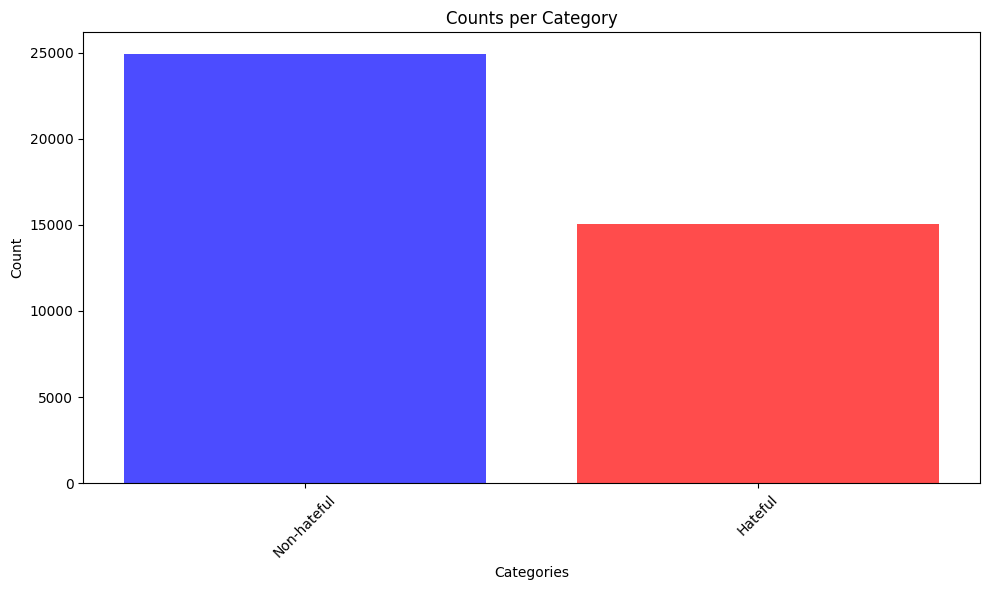

In [3]:
import matplotlib.pyplot as plt

columns = ["Label"] 

for column in columns:
        # Count the occurrences of each label in the column
        label_counts = df[column].value_counts()
        categories = ['Non-hateful','Hateful']  # Category names
        
        # Plot the bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(categories, label_counts, color=['blue','red'], alpha=0.7)
        
        # Add chart title and labels
        plt.title(f'Counts per Category')
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.xticks(categories, rotation=45)  # Customize x-axis labels to display category names
        
        # Show the plot
        plt.tight_layout()
        plt.show()